# Tutorial for the Analysis of Sokoban Logfiles using Machine Learning (3)
# Using Scikit-Learning Package to do Machine Learning

Here we go back to Python again. Of course, R also has libraries dealing with machine learning. The problem is R is not a fast language, while training models may take time, especially if you are doing grid searching to find the optimal hyperparameters. Using Python can greatly save your waiting time. Moreover, Scikit Learning is an extremely completed package, with built-in tools for cross validation and grid searching, which make programming much easier.

So, first, we import several packages.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import tree, feature_selection
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, average_precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle
import os

We use pandas to read the data. Don't worry, the use of pandas here is very basic, which you can easily grasp.

In [2]:
os.chdir(os.pardir)
datafile = 'Rpolar'
dt = pd.read_csv('working_data{}{}.csv'.format(os.sep,datafile))
dt = dt.iloc[:,1:] # pandas use .iloc to index. The first line is the number of each line added by R. 
y = dt.iloc[:,0]
X = dt.iloc[:,1:]
print(X[0:5])
print(y[0:5])

   box_completed.x   dsteps.x  first_move_time.x  first_push_time.x  \
0         2.230769  11.846154           7.396948          14.792457   
1         2.222222   9.666667          15.764540          27.711271   
2         1.666667   0.666667           3.446664           7.933374   
3         2.500000  10.500000          12.370144          14.840164   
4         2.266667   7.400000          30.032463          42.151040   

   guan_time.x  same_p_optimal.x  rest_mean.x  rest_sd.x   p_dup.x  \
0    35.855706          0.627779     0.420156   0.874172  0.028586   
1    65.414082          0.616496     0.659978   2.431729  0.074435   
2    17.553543          1.044991     0.456327   0.695416  0.019608   
3    50.753058          0.637312     0.644768   1.012944  0.062191   
4    62.327346          0.689358     0.454205   2.078735  0.027350   

   f_m_ratio.x     ...        dbox.y  lnfirst_move_time.y  \
0    17.682549     ...      1.428571             3.129904   
1    26.810780     ...      1.

We define a function to do the grid searching, namely, finding the optimal parameters for the model. 

This function uses several buit-in functions in scikit-learning. You should read their documentations carefully.

In [3]:
def gridsearch(X, y, est, param, scoring_method):
    '''
    X, y is the data. 'est' is the estimator we would use, for example, random forest classifier. Or we can 
    also use other estimator like SVM or others.
    
    'param' is the set of parameters which this function will try exaustively to find the best combination.
    
    'scoring method' refers to the method to estimate the result. One common method for regression tasks is R2.
    Precision, Recall, F1 and accuracy are often used in classification tasks.
    '''
    
    varname = X.columns.values
    X = X.values
    y = y.values
    if len(set(y)) != 2:
        categ = 0
        scoring_method = 'r2'
    else:
        categ = 1
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=4) 
    clf = GridSearchCV(estimator=est, param_grid=param, cv=4,
                       n_jobs=-1, scoring=scoring_method)
    clf.fit(X_train, y_train)
    blf = clf.best_estimator_
    res = pd.DataFrame(clf.cv_results_)
    mean = res.loc[res.rank_test_score == 1, 'mean_test_score'].iloc[0]
    std = res.loc[res.rank_test_score == 1, 'std_test_score'].iloc[0]
    print(clf.best_params_)
    print("Grid scores on development set:")
    print("The best performance is %0.3f (+/-%0.03f)" % (mean, 2 * std))
    print()
    scores = cross_val_score(blf, X_train, y_train,
                             cv=4, scoring=scoring_method)
    print('The CV mean is %0.3f, the CV std is %0.3f' %
          (scores.mean(), scores.std()))
    if categ == 0:
        print('clf\t' + str(clf.score(X_test, y_test)))
        print('r2\t' + str(r2_score(y_true, y_pred)))
    if categ == 1:
        scoremat = np.zeros((30, 4))
        for i in range(30):
            y_true, y_pred = y_test, blf.predict(X_test)
            score = np.array([f1_score(y_true, y_pred), average_precision_score(y_true, y_pred),
                              recall_score(y_true, y_pred), accuracy_score(y_true, y_pred)])
            scoremat[i] = score
            blf.fit(X_train, y_train)

        print('f1\t' + 'precision\t' + 'recall\t' + 'Accuracy\t')
#         print(scoremat)
        print()
        mean = scoremat.mean(axis=0)
        std = scoremat.std(axis=0)
        print(mean)
        print(std)
    return (X_train, X_test, y_train, y_test, clf.best_estimator_, varname)

Now we use this function to do the grid search. We use each scoring method ('accuracy', 'average_precision', 'f1' and 'recall') as the optimal target and find the optimal models for them respectively.


    ===========================accuracy===========================
{'max_depth': 5, 'max_features': 16, 'min_samples_split': 8, 'n_estimators': 10}
Grid scores on development set:
The best performance is 0.592 (+/-0.090)

The CV mean is 0.646, the CV std is 0.089
f1	precision	recall	Accuracy	

[ 0.62335382  0.76005583  0.54731183  0.64152047]
[ 0.0509473   0.03598256  0.05617186  0.04477027]


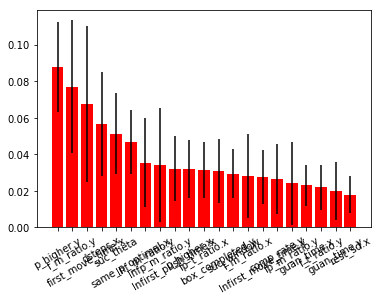


    ===========================average_precision===========================
{'max_depth': 5, 'max_features': 16, 'min_samples_split': 8, 'n_estimators': 10}
Grid scores on development set:
The best performance is 0.612 (+/-0.088)

The CV mean is 0.588, the CV std is 0.040
f1	precision	recall	Accuracy	

[ 0.61992497  0.76279755  0.53978495  0.64327485]
[ 0.0520551   0.03007798  0.07113047  0.03771816]


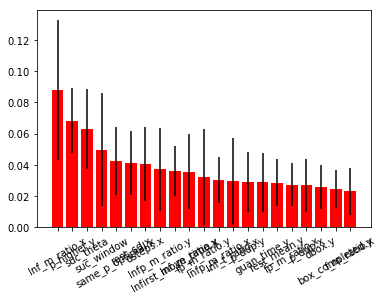


    ===========================f1===========================
{'max_depth': 5, 'max_features': 16, 'min_samples_split': 8, 'n_estimators': 10}
Grid scores on development set:
The best performance is 0.518 (+/-0.179)

The CV mean is 0.589, the CV std is 0.085
f1	precision	recall	Accuracy	

[ 0.62278274  0.76117028  0.54623656  0.64269006]
[ 0.06074531  0.04084505  0.07064115  0.04888903]


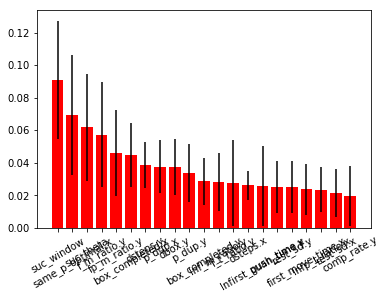


    ===========================recall===========================
{'max_depth': 5, 'max_features': 16, 'min_samples_split': 8, 'n_estimators': 10}
Grid scores on development set:
The best performance is 0.619 (+/-0.199)

The CV mean is 0.600, the CV std is 0.134
f1	precision	recall	Accuracy	

[ 0.62140189  0.7591586   0.54516129  0.63918129]
[ 0.04537872  0.03512532  0.0480995   0.04337352]


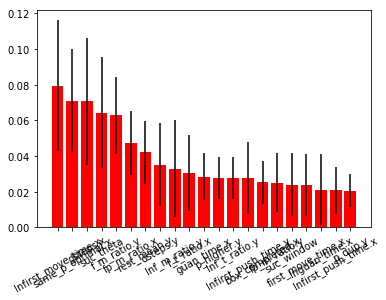

In [4]:
scoring_method_list = ['accuracy', 'average_precision', 'f1', 'recall']
rfc_paraset = {'n_estimators': [5, 10, 50, 150], 'max_depth': [x for x in range(2, 8, 2)], 'max_features': [
            x for x in range(5, 16, 2)], 'min_samples_split': [x for x in range(2, 10, 2)]}
rfc_test = {'n_estimators': [10], 'max_depth': [5], 'max_features': [
            16], 'min_samples_split': [8]}
# searching in rfc_paraset will take a long time, for testing, you can use rfc_test, which has only one combination.
for scoring_method in scoring_method_list:
    print('''
    ==========================={}==========================='''.format(scoring_method))
    X_train, X_test, y_train, y_test, blf, varname = gridsearch(
            X, y, RandomForestClassifier(), rfc_test, scoring_method)
    pickle.dump((X_train, X_test, y_train, y_test, blf, varname),
            open('results'+os.sep+datafile + '_'+ scoring_method + '.pdata', 'wb'))
    # pickle can store binary python object in a file temporaily.
    blf.fit(X_train, y_train)
    #below we obtain the relative importance of features and draw a figure.
    importance = blf.feature_importances_ 
    std = np.std([tree.feature_importances_ for tree in blf.estimators_],
                 axis=0) / (len(blf.estimators_)**0.5)
    indices = np.argsort(importance)[::-1]
    varlist = varname
    indices = indices[:blf.max_features + 5]
    labels = [varlist[i] for i in indices]
    ax = plt.subplot()
    ax.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=30)
    plt.show()


These figures are ugly... I know it. If you would spend enough time on it, you can plot delicate figures, for sure.

Now we have a basic result of ML. **However**, it's only a half of the project. To optimize the result, we still have much work to do, like:
- Finding more features;
- Trying different models other than random forest;
- ...

Work Hard!